In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
data_path = '/content/drive/MyDrive/'
with open('data.txt', 'w') as output_file:
    for input_file in os.listdir(data_path):
        if input_file.endswith('txt'):
            with open('/'.join([data_path, input_file])) as input_file:
                for l in input_file:
                    output_file.write(l)

In [ ]:
import string
exclude = set(string.punctuation)
exclude.remove('.')

text = open('/content/drive/MyDrive/data.txt', 'r').read().lower()
text = ''.join([w for w in text if not w.isdigit() and w not in exclude])
text = nltk.word_tokenize(text)
print (f'Text length: {len(text)} words')
print(text[:25])

Text length: 28185 words
['annotation', 'писарев', 'дмитрий', 'иванович', 'писарев', 'дмитрий', 'иванович', 'историческое', 'развитие', 'европейской', 'мысли', 'д.', 'и.', 'писарев', 'историческое', 'развитие', 'европейской', 'мысли', 'i', 'лет', 'за', 'восемьсот', 'до', 'рождества', 'христова']


In [ ]:
vocab = sorted(set(text))
print (f'Unique words: {len(vocab)}')


Unique words: 9578


In [ ]:
word2idx = {u:i for i, u in enumerate(vocab)}
idx2word = np.array(vocab)

text_as_int = np.array([word2idx[c] for c in text])

In [ ]:
for word, r in zip(word2idx, range(20)):
    print('  {:6s}: {:3d}'.format(repr(word), word2idx[word]))

  '.'   :   0
  '...' :   1
  'a'   :   2
  'ad'  :   3
  'annotation':   4
  'brescia':   5
  'chemise':   6
  'cipher':   7
  'coton':   8
  'dei' :   9
  'development':  10
  'diabolo':  11
  'draper':  12
  'et'  :  13
  'europe':  14
  'fecit':  15
  'finivit':  16
  'gloriam':  17
  'history':  18
  'homagium':  19


In [ ]:
seq_length = 20
examples_per_epoch = len(text) // (seq_length + 1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2word[i.numpy()])

annotation
писарев
дмитрий
иванович
писарев


In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(' '.join(idx2word[item.numpy()])))

'annotation писарев дмитрий иванович писарев дмитрий иванович историческое развитие европейской мысли д. и. писарев историческое развитие европейской мысли i лет за'
'восемьсот до рождества христова полудикий греческий народ с напряженным вниманием и с ребяческою доверчивостью слушал песни странствующих певцов о подвигах геркулеса'
'и тезея о путешествии аргонавтов в колхиду за золотым руном о быстроногом ахиллесе о хитроумном одиссее о падении илиона о несчастиях'
'и преступлениях атридов и потомков кадма . в этих песнях заключалась вся мудрость тогдашнего грека . тут была и религиозная догматика'
'и нравственная философия и история и физика и астрономия все это было смешано в одну пеструю кучу и все вместе считалось'


In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(' '.join(idx2word[input_example.numpy()])))
  print ('Target data:', repr(' '.join(idx2word[target_example.numpy()])))


Input data:  'annotation писарев дмитрий иванович писарев дмитрий иванович историческое развитие европейской мысли д. и. писарев историческое развитие европейской мысли i лет'
Target data: 'писарев дмитрий иванович писарев дмитрий иванович историческое развитие европейской мысли д. и. писарев историческое развитие европейской мысли i лет за'


In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2word[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2word[target_idx])))

Step    0
  input: 4 ('annotation')
  expected output: 5489 ('писарев')
Step    1
  input: 5489 ('писарев')
  expected output: 1827 ('дмитрий')
Step    2
  input: 1827 ('дмитрий')
  expected output: 2617 ('иванович')
Step    3
  input: 2617 ('иванович')
  expected output: 5489 ('писарев')
Step    4
  input: 5489 ('писарев')
  expected output: 1827 ('дмитрий')


In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
EPOCHS = 100

# Length of the vocabulary in chars
vocab_size = len(vocab)

emb_dim = 512

rnn_units = 128 
rnn_units1 = 32 

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [ ]:
def model_GRU(vocab_size, emb_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, emb_dim,
                                batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

model = model_GRU(vocab_size = len(vocab), emb_dim=emb_dim,
                    rnn_units=rnn_units, batch_size=BATCH_SIZE)
model.compile(optimizer='adam', loss=loss)
history2 = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

tf.train.latest_checkpoint(checkpoint_dir)

model = model_GRU(vocab_size, emb_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

Epoch 1/100
20/20 [==============================] - 9s 356ms/step - loss: 9.1179
Epoch 2/100
20/20 [==============================] - 6s 312ms/step - loss: 8.1683
Epoch 3/100
20/20 [==============================] - 6s 314ms/step - loss: 7.8216
Epoch 4/100
20/20 [==============================] - 6s 314ms/step - loss: 7.7560
Epoch 5/100
20/20 [==============================] - 6s 314ms/step - loss: 7.7176
Epoch 6/100
20/20 [==============================] - 6s 314ms/step - loss: 7.6967
Epoch 7/100
20/20 [==============================] - 6s 315ms/step - loss: 7.6616
Epoch 8/100
20/20 [==============================] - 6s 309ms/step - loss: 7.6423
Epoch 9/100
20/20 [==============================] - 6s 312ms/step - loss: 7.6022
Epoch 10/100
20/20 [==============================] - 6s 312ms/step - loss: 7.5603
Epoch 11/100
20/20 [==============================] - 6s 309ms/step - loss: 7.5149
Epoch 12/100
20/20 [==============================] - 6s 310ms/step - loss: 7.4401
Epoch 13/100


In [ ]:
epoch_count = range(1, EPOCHS + 1)

def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 20

  # Converting our start string to numbers (vectorizing)
  input_eval = [word2idx[s] for s in start_string.split()]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2word[predicted_id])

  return (start_string + ' '.join(text_generated))

GRU (10 слов)


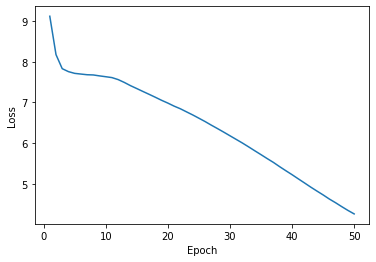

все древние участвовали в воздухе войне этажерки уголовными вычислять и осквернить


In [ ]:
print("GRU (10 слов)")
loss = history2.history['loss']
plt.plot(epoch_count, loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(generate_text(model, start_string=u"все "))

GRU


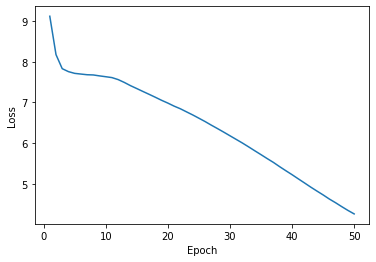

в цветущее время нелепости ловили ужиться достоянием все древние врагов и бороться . по алхимиков и нравственная золотым мужественною мироздания т.


In [ ]:
print("GRU")
loss = history2.history['loss']
plt.plot(epoch_count, loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(generate_text(model, start_string=u"в "))